In [7]:
import warnings

warnings.filterwarnings('ignore')

In [29]:
source = 'sample_data/'
for file in os.listdir(source):
    
  

    if('.xml' in file):
        xml_path = source + file
    if('.jpg' in file):
        image_path = source + file
        
xml_path

'sample_data/201503.20150602.115901553.62766.orig.xml'

In [59]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from Mask_RCNN.mrcnn.utils import Dataset

import numpy as np
 
# class that defines and loads the dataset
# Dataset is a parent!!!
class GetDataset(Dataset):
    
    # load the dataset definitions
    def load_dataset(self, dataset_name):
        
        self.add_class('dataset', 1, dataset_name)
    
        # Will need to change this when we have the 
        # real dataset
        source = 'sample_data/'
        
        xml_path = []
        image_path = []
        image_ids = np.arange(len(os.listdir(source))/2 - 1).astype('int')
        
        for file in os.listdir(source):
            if('.xml' in file):
                xml_path.append(source + file)
            if('.jpg' in file):
                image_path.append(source + file)
                    
        for _ in image_ids:
            self.add_image('dataset', image_id = _, path = image_path[_], annotation = xml_path[_])        
            
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        
        # get the root of the document
        root = tree.getroot()
        
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        return boxes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        
        # get details of image
        info = self.image_info[image_id]
        
        # define box file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
        
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('sand_dollar'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [60]:
dataset_name = 'sand_dollar'

# train set
train_set = GetDataset()
train_set.load_dataset(dataset_name)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = GetDataset()
test_set.load_dataset(dataset_name)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 29
Test: 29


(1024, 1360, 3)
(1024, 1360, 26)


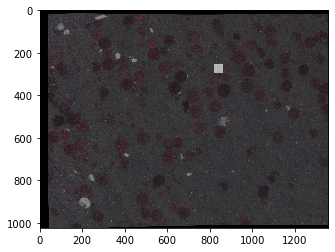

In [74]:
import matplotlib.pyplot as plt

image_id = np.random.randint(29)
image = train_set.load_image(image_id)

print(image.shape)

# load image mask
mask, class_ids = train_set.load_mask(image_id)

print(mask.shape)

# plot image
plt.imshow(image)

# plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()